<a href="https://colab.research.google.com/github/shanekeane/GW_Project/blob/main/Create_Estimator_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This creates an estimator for 3 parameters - frequency, amplitude and phase with default embedding net

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q sbi

     |████████████████████████████████| 283 kB 5.4 MB/s 
     |████████████████████████████████| 718 kB 51.8 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 


In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import normalize
import seaborn as sns
import pickle

# Try with multiple parameters

In [13]:
#Set parameters
low_freq = 20.
high_freq = 30.
num_dim = 3
low_amp = 1.0#np.sqrt(20)
high_amp = 5.0#np.sqrt(50)
low_phase = 0.0
high_phase = np.pi
samp_freq = 128
time_length = 0.25

In [17]:
#Define prior and simulator
prior = utils.BoxUniform(low=torch.Tensor([low_freq, low_amp, low_phase]), 
                         high=torch.Tensor([high_freq, high_amp, high_phase]))

def simulator(params):
    """
    input:  params - a torch array having frequency, amplitude and phase
    
    output: a noisy time series signal of length 1024 (1024Hz for 1s) with SNR 25
    """
    x = torch.linspace(0, time_length, steps=int(samp_freq*time_length))
                         
    return params[1]*torch.sin(2.0*torch.pi*params[0]*x + params[2]) + torch.randn(len(x)) #sinusoid in white noise

simul, prior = prepare_for_sbi(simulator, prior)

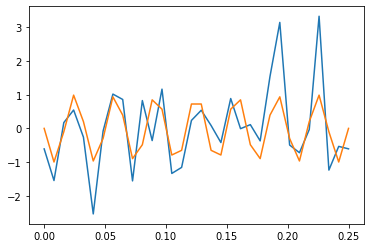

In [20]:
#Plot sample signal and noise
x = torch.linspace(0, time_length, steps=int(samp_freq*time_length))
parameters = torch.Tensor([30.0, 1., np.pi])
plt.plot(x, simulator(parameters))
plt.plot(x, parameters[1]*torch.sin(2.0*torch.pi*parameters[0]*x + parameters[2]))

In [21]:
#Inference part
for num_sims in [1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5]:
  start = time.time()
  inference = SNPE(prior=prior, density_estimator = 'maf') #define inference object
  params, sims = simulate_for_sbi(simul, proposal=prior, num_simulations=int(num_sims))
  density_estimator = inference.append_simulations(params, sims).train()
  posterior = inference.build_posterior(density_estimator)
  end = time.time()
  with open(f'/content/drive/MyDrive/GW_Thesis/posteriors/{int(num_sims)}_{samp_freq}_basic_multiple_posterior.pkl', 'wb') as output:
    pickle.dump(posterior, output)
  print(f'Runtime: {end-start}')

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 65 epochs.Runtime: 14.847158193588257


Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 119 epochs.Runtime: 51.30465888977051


Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 69 epochs.Runtime: 74.61267852783203


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 78 epochs.Runtime: 168.06759810447693


Running 20000 simulations.:   0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 86 epochs.Runtime: 370.3386116027832


Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 90 epochs.Runtime: 966.1094665527344


Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 73 epochs.Runtime: 1572.5706453323364
